# IN PROGRESS!!!

# DNN Model for MIT data 
As we concluded before, for MIT data, we apply the following preprocessing:   
resampling: Oversampling \
rescaling: MinMax Scaler

If you don't have the original files: run the notebook `preprocessing_mit_minmax_oversampling.ipynb`     
Input file: (The preprocessed data)   
mitbih_train_clean_minmax_oversampling.csv   
mitbih_test_clean_minmax_oversampling.csv

Output: DNN model trained  
model_dnn_mit.pkl  

In [2]:
import sys
import os 

data_path = ''
model_output_path = ''
# check if the enviorment is Google Colab 

if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    model_output_path = data_path

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_output_path = '../models/'

Running on local environment
Current working directory: g:\Meine Ablage\heartbeat-analysis-ai\notebooks


## Read data 


In [3]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as ImbPipeline  # Use ImbPipeline for oversampling
import matplotlib.pyplot as plt
import seaborn as sns


RawFiles = dict({
    'train': data_path + 'mitbih_train_clean_minmax_oversampling.csv', 
    'test': data_path + 'mitbih_test_clean_minmax_oversamling.csv'  
})


OutputFiles = dict({
    'model': model_output_path +  'model_dnn_mit.pkl'
})

train = pd.read_csv(RawFiles.get('train'),sep=',',header=0)
test = pd.read_csv(RawFiles.get('test'),sep=',',header=0)

y_train = train['target']
X_train = train.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)



In [6]:
X_train.shape[1]

187

# DNN with MinMax Scaler and Oversampling

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# define model
model = Sequential() # Sequential model is used to add layers one by one to the model, in a linear manner

# Input Layer
model.add(Dense(187, activation='relu', input_shape=(X_train.shape[1],))) # 187 neurons in the input layer, because we have 187 features

# Hidden Layers: 5 hidden layers with 128, 64, 32, 16, and 8 neurons respectively
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu')) 
model.add(BatchNormalization()) # BatchNormalization is used to normalize the activations of the previous layer at each batch
model.add(Dropout(0.3)) # Dropout is used to prevent overfitting. 0.3 means 30% of the neurons will be turned off randomly

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output Layer for binary classification of the target
model.add(Dense(1, activation='sigmoid')) # 1 means 1 neuron in the output layer, sigmoid, because we want to predict probabilities

# compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # adam is a popular optimizer, binary_crossentropy is used for binary classification

model.summary()

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # patience is the number of epochs with no improvement after which training will be stopped
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001) # the factor by which the learning rate will be reduced, min_lr is the lower bound for the learning rate


# Callbacks for plotting
train_loss = [] # to store training loss
val_loss = []
train_accuracy = []
val_accuracy = []

# Define batch size
batch_size = 32  # Adjust this value as needed

# Training
epochs = 200
for epoch in range(epochs):
    history = model.fit(X_train, y_train, epochs=1, batch_size=batch_size, validation_data=(X_test, y_test), 
                        verbose=0, callbacks=[early_stopping, lr_scheduler])
    
    # Append metrics to the respective lists
    train_loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])
    train_accuracy.append(history.history['accuracy'][0])
    val_accuracy.append(history.history['val_accuracy'][0])
    
    # Print progress at each 10th epoch for feedback
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, "
              f"Accuracy: {train_accuracy[-1]:.4f}, Val Accuracy: {val_accuracy[-1]:.4f}")

c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 187)            │        35,156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        24,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,221 (278.21 KB)

 Trainable params: 70,725 (276.27 KB)

 Non-trainable params: 496 (1.94 KB)

Epoch 10/200 - Loss: 0.1049, Val Loss: 0.0766, Accuracy: 0.9660, Val Accuracy: 0.9760
Epoch 20/200 - Loss: 0.0737, Val Loss: 0.0771, Accuracy: 0.9766, Val Accuracy: 0.9794
Epoch 30/200 - Loss: 0.0567, Val Loss: 0.0919, Accuracy: 0.9830, Val Accuracy: 0.9746
Epoch 40/200 - Loss: 0.0473, Val Loss: 0.0853, Accuracy: 0.9855, Val Accuracy: 0.9770
Epoch 50/200 - Loss: 0.0420, Val Loss: 0.0834, Accuracy: 0.9878, Val Accuracy: 0.9807
Epoch 60/200 - Loss: 0.0375, Val Loss: 0.0821, Accuracy: 0.9894, Val Accuracy: 0.9769
Epoch 70/200 - Loss: 0.0322, Val Loss: 0.0860, Accuracy: 0.9907, Val Accuracy: 0.9836
Epoch 80/200 - Loss: 0.0313, Val Loss: 0.0852, Accuracy: 0.9911, Val Accuracy: 0.9830
Epoch 90/200 - Loss: 0.0278, Val Loss: 0.0934, Accuracy: 0.9919, Val Accuracy: 0.9819
Epoch 100/200 - Loss: 0.0253, Val Loss: 0.1029, Accuracy: 0.9930, Val Accuracy: 0.9837
Epoch 110/200 - Loss: 0.0241, Val Loss: 0.1004, Accuracy: 0.9934, Val Accuracy: 0.9804
Epoch 120/200 - Loss: 0.0221, Val Loss: 0.1068, Accu

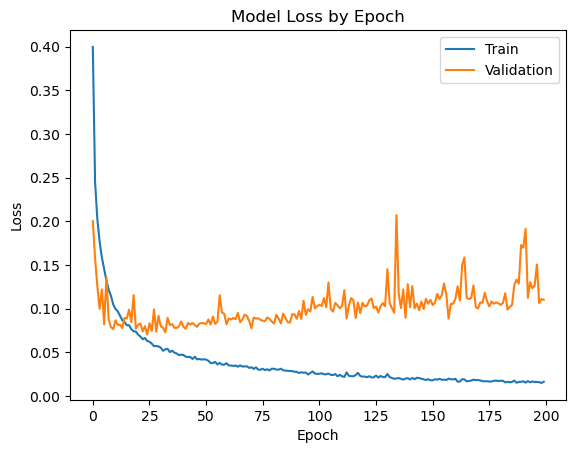

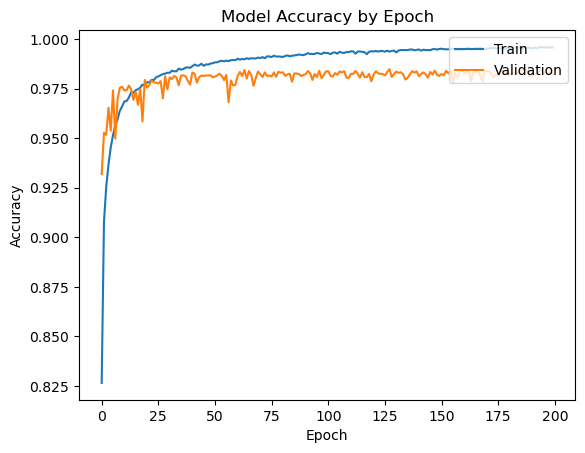

634/634 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step
[[17957   161]
 [  197  1969]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18118
           1       0.92      0.91      0.92      2166

    accuracy                           0.98     20284
   macro avg       0.96      0.95      0.95     20284
weighted avg       0.98      0.98      0.98     20284

F1 Score: 0.9166666666666666


In [9]:
# Plotting the Loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model Loss by Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting the Accuracy
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title('Model Accuracy by Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Making predictions
y_pred = model.predict(X_test)
y_pred_class = (y_pred >= 0.5).astype(int)

# Evaluating the model
print(confusion_matrix(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))
print(f"F1 Score: {f1_score(y_test, y_pred_class)}")

# Save DNN Model

In [11]:
# Save model 
import pickle
# Save the model to a file
with open(OutputFiles.get('model'), 'wb') as model_file:
    pickle.dump(model, model_file)